<a href="https://colab.research.google.com/github/HemantharajM/AI-Material/blob/master/Multi_agent_planning_8.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter

import torch.nn.functional as F

In [0]:
import queue

In [19]:
from google.colab import files
uploaded = files.upload()

Saving MA_P_6_2_2.pth to MA_P_6_2_2.pth


In [0]:
def action(S,val,obst,imsize):
    if val == 0 and S[1].item() > 0:
        if obst[S[0].item()][S[1].item()-1] == 0.0 :
            return torch.tensor([S[0].item(),S[1].item()-1]), False
        else :
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 1 and S[0].item() > 0:
        if obst[S[0].item()-1][S[1].item()] == 0.0 :
            return torch.tensor([S[0].item()-1,S[1].item()]), False
        else :
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 2 and S[1].item() < (imsize -1):
        if obst[S[0].item()][S[1].item()+1] == 0.0 :
            return torch.tensor([S[0].item(),S[1].item()+1]), False
        else:
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 3 and S[0].item() < (imsize -1):
        if obst[S[0].item()+1][S[1].item()] == 0.0 :
            return torch.tensor([S[0].item()+1,S[1].item()]), False
        else:
            return torch.tensor([S[0].item(),S[1].item()]), True
    else :
        return S, True

In [0]:
def rand_play(X,a_s,imsize,obst):
    #find possible action
    Action = []
    
    if (a_s[1] -1) >= 0:
        if X[0][a_s[0]][a_s[1]-1] and (not X[2][a_s[0]][a_s[1]-1]):
            Action.append(0)
    if (a_s[0] -1 ) >= 0:
        if X[0][a_s[0]-1][a_s[1]] and (not X[2][a_s[0]-1][a_s[1]]):
            Action.append(1)
    if (a_s[1] +1 ) < imsize:
        if X[0][a_s[0]][a_s[1]+1] and (not X[2][a_s[0]][a_s[1]+1]):
            Action.append(2)
    if (a_s[0] + 1) < imsize:    
        if X[0][a_s[0]+1][a_s[1]] and (not X[2][a_s[0]+1][a_s[1]]):
            Action.append(3)
    
    if len(Action) != 0:
        act = np.random.choice(Action)
        new_state,_ = action(a_s,act,obst,imsize)
    else:
        new_state = a_s
    
    return new_state

In [0]:
def goal_reach_check(agent_state,goal,goal_count,goal_reached):
    token = 0
    v = 0
    for z in goal:
        #check goal is already reached
        if goal_reached[v] == 0:
            #if goal is not reached and compare with agent state
            if agent_state[0].item() == z[0] and agent_state[1].item() == z[1]:
                goal_reached[v] = 1
                goal_count += 1
                token = 1
        v = v+1    
    return token,goal_count,goal_reached

In [0]:
def agent_env(X,agent_state,imsize,avoid_goal,token):
    
    Y = torch.zeros([1,5,imsize,imsize])
    Y[0,0,:,:] = (X[0] == 0)
    Y[0,1,:,:] = (X[0] == 1)
    Y[0,2,:,:] = X[1].clone()
    
    X[2][agent_state[0]][agent_state[1]] = 0.0
     
    if token :
        Y[0,3,:,:] = X[2].clone()
    else :
        Y[0,3,:,:] = torch.zeros_like(X[2])

        
    #avoid goal 
    for i in avoid_goal:
        Y[0,2,i[0],i[1]] = 0.0
    
    
    Y[0,1,:,:] = Y[0,1,:,:] - Y[0,3,:,:] 
    Y[0,0,:,:] = Y[0,0,:,:] + Y[0,3,:,:]
      
    Y[0,3,:,:] = -1 * Y[0,3,:,:]
    
    Y[0,4,agent_state[0],agent_state[1]] = 1.0
    
    
    Y = Y.float()
   
    return Y

In [0]:
def agent_prediction(model,X,whole_traj_act,goal,imsize,max_random_play):
    #convert specific domain to generic domains
    X = abs(X)
    
    model.eval() 
    correct_goal,total_goal,traj_step_error,goal_count = 0.0,0.0,0.0,0.0
    
    #store agent initial state
    inter = np.where(X[2] == 1.0)
    agent_state = np.column_stack([inter[0],inter[1]])
    n_agent = agent_state.shape[0]
    
    agent_traj = [[agent_state[i].copy()] for i in range(n_agent)]
    
    #store number agent still playing
    current_play_agent = [1.0 for i in range(n_agent)]
    
    current_play_agent = np.array(current_play_agent)
    
    #keep which is reached
    goal_reached = np.zeros([goal.size])
    
    #store each agent random play chances
    random_play = np.zeros(n_agent)
    max_random_play = max_random_play
    
    play = 0
    while current_play_agent.sum() != 0.0 and play < 20:
        play += 1
        for i in range(n_agent):
            
            if current_play_agent[i] == 1.0:  
                Input = agent_env(X.clone(),agent_state[i],imsize,[],1)
                Input = Input.to(device)
                S1 = torch.tensor(agent_state[i][0])
                S1 = S1.to(device)
                S2 = torch.tensor(agent_state[i][1])
                S2 = S2.to(device)
                output,prediction,_,_ = model(Input,S1,S2)
                _,index = torch.max(output,dim=1)
                
                #check agent (index = 4) means stop planning
                if index == 4:
                    #token whether agent reach goal or not
                    token,goal_count,goal_reached = goal_reach_check(agent_state[i],goal,goal_count,goal_reached)
                    if token:
                        current_play_agent[i] = 0.0
                    else:
                        if random_play[i] >= max_random_play:
                            current_play_agent[i] = 0.0
                        else:
                            X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                            agent_state[i] =rand_play(X,agent_state[i].copy(),imsize)
                            random_play[i] += 1
                            X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                            agent_traj[i].append(agent_state[i].copy())
    
                else:
                    
                    agent_new_state,obst = action(S=agent_state[i],val=index,imsize=imsize,obst=Input[0,0,:,:])
                    
                    if obst:
                        current_play_agent[i] = 0.0
                        continue
                    X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                    agent_state[i] = agent_new_state
                    #check agent reach any obstacle and push it into stop
                    i_1 = agent_state[i][0]
                    i_2 = agent_state[i][1]
                    if X[0][i_1][i_2].item() == 0.0 and X[1][i_1][i_2].item() == 0.0:
                        current_play_agent[i] = 0.0
                        
                    X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                    agent_traj[i].append(agent_state[i].copy())
                    
                    #stop agent which moves back and forward two on the goal
                    if len(agent_traj[i]) > 3 and (agent_traj[i][-1] == agent_traj[i][-3]).sum() == 2 and (agent_traj[i][-2] == agent_traj[i][-4]).sum() == 2:
                        
                        inter = agent_traj[i][-1]
                        token,goal_count,goal_reached = goal_reach_check(inter,goal,goal_count,goal_reached)
                        if token:
                            current_play_agent[i] = 0.0
                        else:     
                            inter = agent_traj[i][-2]
                            token,goal_count,goal_reached = goal_reach_check(inter,goal,goal_count,goal_reached)
                            if token:
                                current_play_agent[i] = 0.0
                                agent_traj[i].pop(-1)
                            else:
                                if random_play[i] < max_random_play:
                                    X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                                    
                                    agent_state[i] =rand_play(X,agent_state[i].copy(),imsize)
                                    random_play[i] += 1
                                    X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                                    agent_traj[i].append(agent_state[i].copy())
                                else:
                                    current_play_agent[i] = 0.0
                    
    for j in range(len(whole_traj_act)):
        inter =  whole_traj_act[j][0][0].numpy() 
        for i in range(len(agent_traj)):
            if inter[0] == agent_traj[i][0][0] and inter[1] == agent_traj[i][0][1]:
                actual_len = len(agent_traj[i])
                pred_len = len(whole_traj_act[j][0])
                traj_step_error += (abs(pred_len - actual_len))
    
    
    correct_goal = goal_count
    
    if n_agent > len(goal):
        total_goal = len(goal)
    else:
        total_goal =  n_agent
        
    traj_step = -1000
    for i in agent_traj:
        if len(i) > traj_step:
            traj_step = len(i)
    
    return correct_goal,total_goal,(traj_step),agent_traj

In [0]:
def visualization(dom,whole_traj_act,traj):
    fig, ax = plt.subplots()
    implot = plt.imshow(dom, cmap="Greys_r")

    opti = []
    for i in whole_traj_act:
        opti.append(i[0])

    for i in opti:
        opti_arr =  []
        for j in i:
            opti_arr.append([j[0].item(),j[1].item()])

        opti_ar = np.array(opti_arr)
        ax.plot(opti_ar[:,1], opti_ar[:,0], c='b')

    start = []
    for i in traj:
        start.append(i[0])

    #start = np.array(start)
    for i in start:
        ax.plot(i[1], i[0], '-s')

    start = []
    for i in traj:
        path = []
        for j in i:
            path.append(j)

        path = np.array(path)
        ax.plot(path[:, 1], path[:, 0], '-X', c='r')

 #   for i in goal:
 #       ax.plot(i[1], i[0], '-s')
    legend = ax.legend(loc='upper right', shadow=False)
#    for label in legend.get_texts():
#        label.set_fontsize('x-small')  # the legend text size
#    for label in legend.get_lines():
#        label.set_linewidth(0.5)  # the legend line width
    plt.draw()
    plt.show()

In [0]:
def next_goal(Input,v_in,agent_pose,imsize,n_goal,goal_pose,avoid_goal) :
    visited = Input[0,0,:,:].clone()
    distance = torch.zeros_like(visited)
    parent = torch.ones_like(visited) * -1

    v_in = v_in.squeeze()
  
    pose = agent_pose

    visited[pose[0]][pose[1]] = 1.0
    distance[pose[0]][pose[1]] = 0.0
    parent[pose[0]][pose[1]] = 4

    av = len(avoid_goal)
    #valid goal location
    valid = [1.0 for i in range(n_goal)]
    for i in range(n_goal):
        for j in range(av):
            if avoid_goal[j][0] == goal_pose[i][0] and avoid_goal[j][1] == goal_pose[i][1]:
                valid[i] = 0.0
                
    S = queue.Queue()
    S.put(pose)

    dist = 0
    
    while not S.empty():
     
        node = S.get()

        node = torch.tensor(node)
        pose = node.clone()

        token = 1
        act_store = [-1,-1]
        dist += 1
        traj = [pose]

        loc = 0
        path_distance = 0
        #check for where this node
        while True:
   
            loc = loc + 1
            path_distance += 1
            pre_pose = pose
            act = v_in[pose[0]][pose[1]]

            act_store[loc % 2] = act

            #check for goal 
            goal_position = -1
            for j in range(n_goal):
                if valid[j] == 1.0:
                    if pose[0] == goal_pose[j][0] and pose[1] == goal_pose[j][1]:
                        goal_position = j
            if goal_position != -1:
                break
            #repeat same two action
            if (act_store[0]== 1 and act_store[1] == 3) or (act_store[0] == 3 and act_store[1] == 1):
                token = 0
                break

            if (act_store[0]== 0 and act_store[1] == 2) or (act_store[0] == 2 and act_store[1] == 0):
                token = 0
                break   

            if act.item() == 4:
                goal_position = -1
                for j in range(n_goal):
                    if pose[0] == goal_pose[j][0] and pose[1] == goal_pose[j][1]:
                        goal_position = j
                if goal_position != -1:
                    break
                else :
                    token = 0
                    break

            pose,obst = action(pose,act,Input[0,0,:,:].squeeze(),imsize)   

            traj.append(pose)

            #Hitting obstacle
            if obst:
                token = 0
                break
            #repeat same position    
            if pose[0] == pre_pose[0] and pose[1] == pre_pose[1]:
                token = 0
                break

        if token :
            pose = traj[0]

            traj1 = []
            while True:

                act = parent[pose[0]][pose[1]]
                if act == 4:
                    break
                pose,obst = action(pose,act,Input[0,0,:,:].squeeze(),imsize)  
                traj1.append(pose)
                path_distance += 1
            traj1.reverse()
            traj1.extend(traj)
            return goal_position,path_distance,traj1
        else :
            pose = node.clone()
            for i in range(4):
                new_pose,obst = action(pose,i,Input[0,0,:,:].squeeze(),imsize) 
                if not obst:
                    if visited[new_pose[0]][new_pose[1]] == 0:
                        S.put(new_pose)
                        visited[new_pose[0]][new_pose[1]] = 1.0
                        distance[new_pose[0]][new_pose[1]] = dist
                        if i == 3:
                            parent[new_pose[0]][new_pose[1]] = 1
                        if i == 2:
                            parent[new_pose[0]][new_pose[1]] = 0
                        if i == 1:
                            parent[new_pose[0]][new_pose[1]] = 3
                        if i == 0:
                            parent[new_pose[0]][new_pose[1]] = 2
    return -1,0,[]

In [0]:
def find_next_goal(X,agent_pose,imsize,avoid_goal,model,agent_no,n_goal,goal_pose):
    
    model.eval()
    token = 0
    
    Input = agent_env(X.clone(),agent_pose,imsize,avoid_goal,token)
    Input = Input.to(device)
    S1 = torch.tensor(agent_pose[0])
    S2 = torch.tensor(agent_pose[1])
    S1 = S1.to(device)
    S2 = S2.to(device)
    output,prediction,v_max,v_in = model(Input,S1,S2)
    
    return next_goal(agent_pose=agent_pose,imsize=imsize,Input=Input,v_in=v_in,goal_pose=goal_pose,n_goal=n_goal,avoid_goal=avoid_goal)

In [0]:
def cooperative(X,model,imsize):
    age = np.where(X[2] == 1.0)
    agent_pose = np.column_stack([age[0],age[1]])
    n_agent = agent_pose.shape[0]

    go = np.where(X[1] == 1.0)
    goal_pose = np.column_stack([go[0],go[1]])
    n_goal = goal_pose.shape[0]

    change = 0
    if n_agent >= n_goal:
        temp = n_goal
        n_goal= n_agent
        n_agent = temp

        temp = agent_pose.copy()
        agent_pose = goal_pose.copy()
        goal_pose = temp.copy()

        temp = X[2].clone()
        X[2] = X[1].clone()
        X[1] = temp.clone()

        change = 1

    goal_agent = [[] for i in range(n_goal)]

    avoid_goal = [[] for i in range(n_agent)]

    trajectory = [[] for i in range(n_agent)]

    #find next goal for all agent
    for i in range(n_agent):
       # print(agent_pose,avoid_goal,goal_pose)
        g_pos,dist,traj = find_next_goal(X.clone(),agent_pose[i],imsize,avoid_goal[i],model,i,n_goal,goal_pose)
        goal_agent[g_pos].append([i,dist])
        #print(g_pos,dist,traj)
        trajectory[i].append(traj)
    
    count = 0
    while count < (n_agent * 10):
        count = count + 1
        token = 1
       # print(goal_agent,avoid_goal)
        for key1 in range(n_goal):
            if len(goal_agent[key1]) > 1:
                token = 0
        if token:
            count = 0
            for i in range(n_goal):
                if len(goal_agent[i]) == 1:
                    count += 1
            agent_traj = [[] for v in range(n_agent)]
            traj_length = -1000
            for v in range(n_agent):
                agent_traj[v].append(trajectory[v][-1])
                if len(trajectory[v][-1]) > traj_length:
                    traj_length = len(trajectory[v][-1])
                    
            return count,n_agent,traj_length,agent_traj
        #find the conflict
        for key1 in range(n_goal):
            #check for conflict
            if len(goal_agent[key1]) > 1:
                same_agent = []
                min_dist = 100
                min_index = -1
                for j in goal_agent[key1]:
                    same_agent.append(j[0])
                    if min_dist > j[1]:
                        min_dist = j[1]
                        min_index = j[0]

                next_goal_agent = [[] for i in range(n_goal)]

                #find goal next goal for conflicted agent
                L = len(same_agent)
                problem = 0
                for age in same_agent:
                    avoid_goal[age].append(goal_pose[key1])
                    g_pos,dist,traj = find_next_goal(X.clone(),agent_pose[age],imsize,avoid_goal[age],model,age,n_goal,goal_pose)
                    if g_pos != -1:
                        trajectory[age].append(traj)
                        next_goal_agent[g_pos].append([age,dist])
                    else :
                        problem = 1
                        avoid_goal[age].pop(-1)
                        for j in goal_agent[key1]:
                            if j[0] == age:
                                next_goal_agent[key1].append([j[0],j[1]])
                
               # print(next_goal_agent)
                #check for newly created conflict
                new_conflict = 0
                new_conflict_index = []

                for v in range(n_goal):
                    if len(next_goal_agent[v]) > 1:
                        new_conflict +=1
                        new_conflict_index.append(v)


                next_next_goal_agent = [[] for i in range(n_goal)]
                
                if new_conflict == 0 and problem == 1:
                    goal_agent[key1] = []
                    for key in range(n_goal):
                        for j in next_goal_agent[key]:
                            goal_agent[key].append(j)
                #No new conflict
                if new_conflict == 0 and problem == 0:
                    avoid_goal[min_index].pop(-1)
                    trajectory[min_index].pop(-1)
                    for key in range(n_goal):
                        if len(next_goal_agent[key]) == 1:
                            #find where this agent made goal and make them null set
                            if next_goal_agent[key][0][0] == min_index:
                                next_goal_agent[key] = []
                    
                    next_goal_agent[key1].append([min_index,min_dist])
                #    print(next_goal_agent)
                    goal_agent[key1] = []
                    for key in range(n_goal):
                        for j in next_goal_agent[key]:
                            goal_agent[key].append(j)
                else :
                    for key2 in new_conflict_index:
                        #code for same agent or partial agent
                        max_dist = 0
                        max_index = -1
                        for j in next_goal_agent[key2]:
                            if max_dist < j[1]:
                                max_dist = j[1]
                                max_index = j[0]

                        for j in next_goal_agent[key2]:
                            #put largest dist to goal
                            if j[0] == max_index:
                                trajectory[max_index].pop(-1)
                                avoid_goal[max_index].pop(-1)
                                for c in range(n_goal):
                                    for d in goal_agent[c]:
                                        if d[0] == max_index:
                                            next_next_goal_agent[key1].append([d[0],d[1]])
                            else :
                                next_next_goal_agent[key2].append([j[0],j[1]])

                        goal_agent[key1] = []
                        for key in range(n_goal):
                            for j in next_next_goal_agent[key]:
                                goal_agent[key].append(j)
                                
                                
    for i in range(n_goal):
        if len(goal_agent[i]) == 1:
            count += 1
    agent_traj = [[] for v in range(n_agent)]
    traj_length = -1000
    for v in range(n_agent):
        agent_traj[v].append(trajectory[v][-1])
        if len(trajectory[v][-1]) > traj_length:
            traj_length = len(trajectory[v][-1])
                    
    return count,n_agent,traj_length,agent_traj

In [0]:
class MA_P(torch.nn.Module):
    def __init__(self, k, imsize):
        super(MA_P, self).__init__()
        self.k = k
        self.imsize = imsize
        self.h = torch.nn.Conv2d(
            in_channels=5,
            out_channels=150,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True)
        self.r = torch.nn.Conv2d(
            in_channels=150,
            out_channels=1,
            kernel_size=(1, 1),
            stride=1,
            padding=0,
            bias=False)
        self.q = torch.nn.Conv2d(
            in_channels=1,
            out_channels=5,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=False)
        
        self.w = Parameter(torch.zeros(5, 1, 3, 3), requires_grad=True)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, X, S1, S2):
        inter = torch.tensor([[[[0,1,0],[1,1,1],[0,1,0]]],[[[0,1,0],[1,1,1],[0,1,0]]],[[[0,1,0],[1,1,1],[0,1,0]]],[[[0,1,0],[1,1,1],[0,1,0]]],[[[0,1,0],[1,1,1],[0,1,0]]]])
        inter = inter.float()
        
        inter = inter.to(device)
        
        h = self.h(X)
        r = self.r(h)
        
        q_1 = inter * self.q.weight
        q = F.conv2d(input= r,weight=q_1,stride=1,padding=1)
     
        v, _ = torch.max(q, dim=1, keepdim=True)
        
        w_1 = inter * self.w
        for i in range(0, self.k - 1):
            q = F.conv2d(
                torch.cat([r, v], 1),
                torch.cat([q_1, w_1], 1),
                stride=1,
                padding=1)
            v, _ = torch.max(q, dim=1, keepdim=True)

        q = F.conv2d(
            torch.cat([r, v], 1),
            torch.cat([q_1, w_1], 1),
            stride=1,
            padding=1)
        
        v_in,v_out = torch.max(q, dim=1, keepdim=True)

        slice_s1 = S1.long().expand(self.imsize, 1, 5, q.size(0))
        slice_s1 = slice_s1.permute(3, 2, 1, 0)
        q_out = q.gather(2, slice_s1).squeeze(2)

        slice_s2 = S2.long().expand(1, 5, q.size(0))
        slice_s2 = slice_s2.permute(2, 1, 0)
        q_out = q_out.gather(2, slice_s2).squeeze(2)

        logits = q_out
        
        return logits, self.sm(logits),v_in,v_out

In [0]:
test = []
with np.load('train_4_0.npz',mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    
    
    p_env = np.zeros([7,7])
    p_env[1:6,1:6] = env
    p_goal = np.zeros([7,7])
    p_goal[1:6,1:6] = goal
    p_agent = np.zeros([7,7])
    p_agent[1:6,1:6] = Agent
    
    domain = np.array([p_env,p_goal,p_agent])
    test_data.append([torch.tensor(domain),torch.tensor([i[2][0]+1,i[2][1]+1]),torch.tensor(i[3])])

In [20]:
model_5x5 = MA_P(8,7)
model_5x5.load_state_dict(torch.load('MA_P_6_2_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [23]:
model_5x5.cuda()

MA_P(
  (h): Conv2d(5, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

In [30]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        #correct_goal,total_goal, traj_length,traj = agent_prediction(model_5x5,prev_env.clone(),whole_traj_act,goal,7,0)
        correct_goal,total_goal, traj_length,traj = cooperative(model=model_5x5,X=prev_env.clone(),imsize=7)
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Goal_accuray: 0.9944547134935305
7532.0 7574.0
Average_Step_error_in_each_domain : 3.9979641693811074
19638.0 4912.0


In [0]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model,prev_env.clone(),whole_traj_act,goal,7,0)
        #correct_goal,total_goal, traj_length,traj = cooperative(model=model,X=prev_env.clone(),imsize=7)
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

In [0]:
test = []
with np.load('train_4_data.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']


In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    
    
    p_env = np.zeros([10,10])
    p_env[1:9,1:9] = env
    p_goal = np.zeros([10,10])
    p_goal[1:9,1:9] = goal
    p_agent = np.zeros([10,10])
    p_agent[1:9,1:9] = Agent
    
    domain = np.array([p_env,p_goal,p_agent])
    test_data.append([torch.tensor(domain),torch.tensor([i[2][0]+1,i[2][1]+1]),torch.tensor(i[3])])

In [57]:
model_8x8 = MA_P(10,10)
model_8x8.load_state_dict(torch.load('MA_P_6_2_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [58]:
model_8x8.cuda()

MA_P(
  (h): Conv2d(5, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [65]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        #correct_goal,total_goal, traj_length,traj = agent_prediction(model_8x8,prev_env.clone(),whole_traj_act,goal,10,0)
        correct_goal,total_goal, traj_length,traj = cooperative(model=model_8x8,X=prev_env.clone(),imsize=10)
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Goal_accuray: 0.9906044033094937
7064.0 7131.0
Average_Step_error_in_each_domain : 5.944061302681992
23271.0 3915.0


In [0]:
test = []
with np.load('test_16x16_data.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    
    
    p_env = np.zeros([18,18])
    p_env[1:17,1:17] = env
    p_goal = np.zeros([18,18])
    p_goal[1:17,1:17] = goal
    p_agent = np.zeros([18,18])
    p_agent[1:17,1:17] = Agent
    
    domain = np.array([p_env,p_goal,p_agent])
    test_data.append([torch.tensor(domain),torch.tensor([i[2][0]+1,i[2][1]+1]),torch.tensor(i[3])])

In [77]:
model_16x16 = MA_P(20,18)
model_16x16.load_state_dict(torch.load('MA_P_6_2_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [78]:
model_16x16.cuda()

MA_P(
  (h): Conv2d(5, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [80]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model_16x16,prev_env.clone(),whole_traj_act,goal,18,0)
        #correct_goal,total_goal, traj_length,traj = cooperative(model=model_16x16,X=prev_env.clone(),imsize=18)
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

Goal_accuray: 0.7518796992481203
100.0 133.0
Average_Step_error_in_each_domain : 7.163265306122449
351.0 49.0


In [0]:
test = []
with np.load('Env_28x28.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])
    

In [119]:
model_28x28 = MA_P(36,32)
model_28x28.load_state_dict(torch.load('MA_P_6_2_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [120]:
model_28x28.cuda()

MA_P(
  (h): Conv2d(5, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

In [132]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 32
max_rand_play= 0
memory = []
for i in range(1):
    if i == 22 or i == 44 or i == 26:
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,32,32])
    
    Y[:,2:30,2:30] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    #correct_goal,total_goal, traj_length,traj = agent_prediction(model_28x28,Y.clone(),[],goal,imsize,0)
    correct_goal,total_goal, traj_length,traj = cooperative(model=model_28x28,X=Y.clone(),imsize=imsize)
    
    for j in traj:
      for k in j:
         print(k,end="->")
      print("End")
      
    print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[tensor([ 3, 11]), tensor([ 2, 11]), tensor([ 2, 10])]->End
[tensor([13,  3]), tensor([12,  3]), tensor([11,  3]), tensor([10,  3]), tensor([9, 3]), tensor([9, 4]), tensor([9, 5]), tensor([9, 6]), tensor([9, 7]), tensor([9, 8]), tensor([9, 9]), tensor([ 9, 10]), tensor([ 9, 11]), tensor([ 9, 12]), tensor([ 9, 13]), tensor([ 9, 14]), tensor([ 9, 15])]->End
[tensor([20, 23]), tensor([20, 24]), tensor([20, 25]), tensor([19, 25]), tensor([19, 26]), tensor([18, 26]), tensor([18, 27]), tensor([17, 27]), tensor([17, 28])]->End
[tensor([21, 28]), tensor([20, 28]), tensor([19, 28]), tensor([18, 28]), tensor([17, 28]), tensor([16, 28]), tensor([15, 28]), tensor([15, 27]), tensor([14, 27])]->End
[tensor([22,  4]), tensor([21,  4]), tensor([20,  4]), tensor([19,  4]), tensor([19,  5])]->End
[tensor([24, 10]), tensor([24,  9]), tensor([23,  9]), tensor([22,  9]), tensor([21,  9]), tensor([20,  9]), tensor([19,  9]), tensor([19, 10]), tensor([19, 11]), tensor([19, 12]), tensor([18, 12]), tensor([17,

45 1
44 1
33 1
32 1
25 1
23 1
20 1
19 1
18 1

In [138]:
age = np.where(Y[2] == 1.0)
agent = np.column_stack([age[0],age[1]])
print(agent)

[[ 2 10]
 [ 9 15]
 [12 11]
 [14 27]
 [17 28]
 [19  5]
 [21 24]]


In [137]:
go = np.where(Y[1] == 1.0)
goa = np.column_stack([go[0],go[1]])
print(goa)

[[ 3 11]
 [13  3]
 [20 23]
 [21 28]
 [22  4]
 [24 10]
 [25 11]]


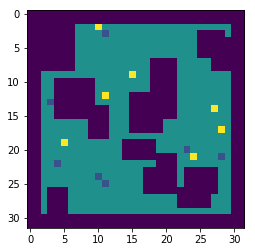

In [142]:
plt.imshow(Y[0].detach().cpu().squeeze() - 0.5 * Y[1].detach().cpu().squeeze()+ Y[2].detach().cpu().squeeze())

In [0]:
goal

array([[ 2,  7],
       [ 3,  9],
       [11, 25],
       [16, 17],
       [21, 15],
       [25, 16]])

In [0]:
memory[3][-1][1][0][0][25][16]

tensor(4, device='cuda:0')

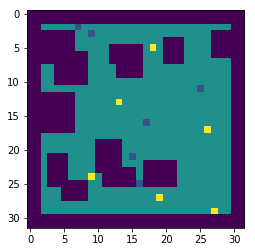

In [0]:
plt.imshow(Y[0]- 0.5*Y[1] + Y[2])

No handles with labels found to put in legend.


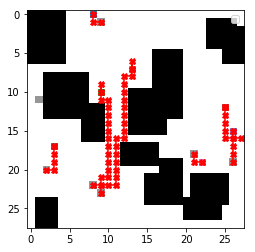

No handles with labels found to put in legend.


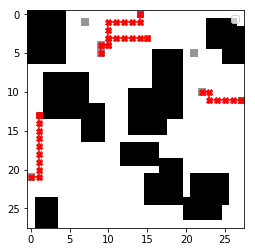

No handles with labels found to put in legend.


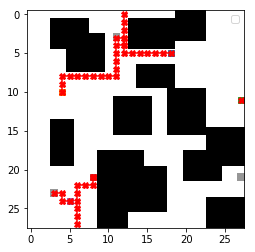

No handles with labels found to put in legend.


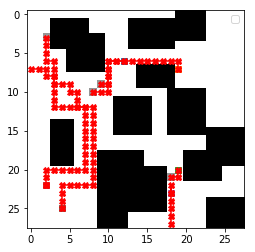

No handles with labels found to put in legend.


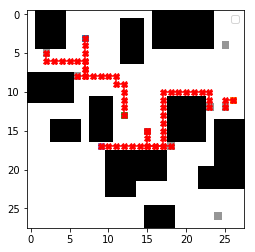

Goal Accuracy: 0.9130434782608695
21.0 23.0


In [0]:
correct_goal,total_goal = 0.0,0.0   
imsize = 28
max_rand_play= 0
for i in range(5):
    X = test_data[i][0].clone()
    
    go = np.where(X[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
        
    current_goal,current_total,traj = agent_predict(model_28x28,X.clone(),goal,imsize,max_rand_play)
    
    visualization(X,traj,imsize)
    
    correct_goal += current_goal
    total_goal += current_total
    
print(f'Goal Accuracy: {correct_goal/total_goal}')
print(correct_goal,total_goal)

In [0]:
test = []
with np.load('Env_32x32.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [157]:
model_32x32 = MA_P(36,36)
model_32x32.load_state_dict(torch.load('MA_P_6_2_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [158]:
model_32x32.cuda()

MA_P(
  (h): Conv2d(5, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [161]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 36
max_rand_play= 0
memory = []
for i in range(50):
    if i == 5 :
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,36,36])
    
    Y[:,2:34,2:34] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    correct_goal,total_goal, traj_length,traj = agent_prediction(model_32x32,Y.clone(),[],goal,imsize,0)
    #correct_goal,total_goal, traj_length,traj = cooperative(model=model_32x32,X=Y.clone(),imsize=imsize)
    
    #for j in traj:
     # for k in j:
      #   print(k,end="->")
     # print("End")
      
    print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

0 2.0 5
1 3.0 4
2 2.0 6
3 2.0 4
4 4.0 6
6 1.0 2
7 4.0 5
8 2.0 5
9 1.0 4
10 0.0 2
11 2.0 2
12 1.0 2
13 1.0 4
14 1.0 3
15 2.0 2
16 2.0 2
17 1.0 5
18 2.0 5
19 0.0 4
20 1.0 4
21 1.0 3
22 2.0 4
23 1.0 4
24 2.0 5
25 2.0 2
26 1.0 5
27 2.0 3
28 3.0 4
29 1.0 3
30 1.0 2
31 1.0 3
32 3.0 5
33 0.0 3
34 2.0 2
35 1.0 3
36 1.0 2
37 4.0 6
38 1.0 3
39 2.0 3
40 2.0 5
41 2.0 3
42 3.0 4
43 0.0 2
44 1.0 2
45 1.0 3
46 1.0 5
47 3.0 5
48 1.0 2
49 1.0 2
Goal Accuracy: 0.45977011494252873
80.0 174.0
Average traj step length : 7.38
369.0 50


In [0]:
test = []
with np.load('Env_64x64.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [168]:
model_64x64 = MA_P(64,68)
model_64x64.load_state_dict(torch.load('MA_P_6_2_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [169]:
model_64x64.cuda()

MA_P(
  (h): Conv2d(5, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [172]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 68
max_rand_play= 0
memory = []
for i in range(50):
    if i == 17 :
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,68,68])
    
    Y[:,2:66,2:66] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    #correct_goal,total_goal, traj_length,traj = agent_prediction(model_64x64,Y.clone(),[],goal,imsize,0)
    correct_goal,total_goal, traj_length,traj = cooperative(model=model_64x64,X=Y.clone(),imsize=imsize)
    
    #for j in traj:
     # for k in j:
      #   print(k,end="->")
      #print("End")
      
    print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 4 4
1 3 3
2 4 4
3 4 4
4 5 5
5 5 5
6 5 5
7 5 5
8 6 6
9 3 3
10 3 3
11 3 3
12 3 3
13 3 4
14 4 4
15 3 4
16 3 3
18 4 4
19 4 4
20 4 5
21 4 4
22 3 3
23 4 5
24 3 3
25 3 3
26 6 6
27 6 7
28 3 4
29 4 4
30 5 5
31 4 4
32 4 4
33 3 3
34 6 6
35 4 4
36 3 3
37 6 6
38 4 5
39 5 5
40 5 5
41 4 4
42 4 4
43 4 4
44 6 6
45 4 4
46 3 3
47 6 6
48 5 5
49 3 3
Goal Accuracy: 0.9665071770334929
202.0 209.0
Average traj step length : 41.1
2055.0 50


In [0]:
3*28*28

2352

In [0]:
test = []
with np.load('Env_80x80.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [0]:
model_80x80 = MA_P(84,84)
model_80x80.load_state_dict(torch.load('MA_P_2_9_2.pth'))
model_80x80.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
correct_goal,total_goal = 0.0,0.0   
imsize = 84
max_rand_play= 0
for i in range(50):
   
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,imsize,imsize])
    Y[:,2:imsize-2,2:imsize-2] = X
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
        
    current_goal,current_total,traj,_ = agent_predict(model_80x80,Y.clone(),goal,imsize,max_rand_play)
    
    correct_goal += current_goal
    total_goal += current_total
    
print(f'Goal Accuracy: {correct_goal/total_goal}')
print(correct_goal,total_goal)

Goal Accuracy: 0.7871621621621622
233.0 296.0


In [0]:
test = []
with np.load('Env_128x128.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [0]:
model_128x128 = MA_P(88,130)
model_128x128.load_state_dict(torch.load('MA_P_2_9_2.pth'))
model_128x128.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

NameError: ignored

In [0]:
correct_goal,total_goal = 0.0,0.0   
imsize = 130
max_rand_play= 0
for i in range(50):
    print(i)
    X = test_data[i][0].clone()
    Y = torch.zeros([3,imsize,imsize])
    Y[:,1:imsize-1,1:imsize-1] = X
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
        
    current_goal,current_total,traj,_ = agent_predict(model_128x128,Y.clone(),goal,imsize,max_rand_play)
    
    correct_goal += current_goal
    total_goal += current_total
    
print(f'Goal Accuracy: {correct_goal/total_goal}')
print(correct_goal,total_goal)

0


RuntimeError: ignored

In [0]:
X>r

0